# Binary classification dataset with Scikit-Learn's make_moons() function

In [114]:
# Import libraries
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [115]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [116]:
# Set random seed for reporductivity
RANDOM_SEED = 42

## 1. Prepare data

In [117]:
# Create a dataset with Scikit-Learn make_moons()

X, y = make_moons(n_samples=2000,
                 shuffle=True,
                 noise=0.1,
                 random_state=RANDOM_SEED)

X[:10], y[:10]

(array([[ 1.7765071 ,  0.19275202],
        [ 0.39780872,  0.93039011],
        [ 0.49530794, -0.31832132],
        [-0.94894379,  0.16301974],
        [ 0.48495693, -0.33816023],
        [ 0.19077838, -0.29968327],
        [-0.83158119,  0.27567682],
        [ 1.63051775, -0.28142796],
        [ 0.94701783,  0.41066225],
        [ 0.51121102, -0.30687196]]),
 array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1], dtype=int64))

In [118]:
# Convert data to pandas dataframe
df_moons = pd.DataFrame({"X1":X[:, 0],
                         "X2":X[:, 1],
                         "label":y})
df_moons.head()

,X1,X2,label
0,1.776507,0.192752,1
1,0.397809,0.930390,0
2,0.495308,-0.318321,1
3,-0.948944,0.163020,0
4,0.484957,-0.338160,1


In [119]:
# Check dataset's balance
df_moons["label"].value_counts()

1    1000
0    1000
Name: label, dtype: int64

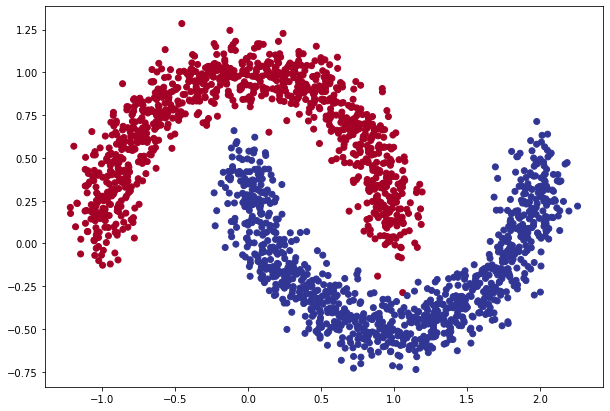

In [120]:
# Visualize the data
plt.figure(figsize=(10, 7))
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [121]:
# Convert data to tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X.shape, X.dtype, y.shape, y.dtype

(torch.Size([2000, 2]), torch.float32, torch.Size([2000]), torch.float32)

In [122]:
# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(1600, 400, 1600, 400)

## 2. Create a model

In [123]:
# Build model by subclassing nn.Module

class MoonModel(nn.Module):
  def __init__(self):
    super().__init__()
        
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=2, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=1)
        )
        
  def forward(self, x):
    return self.layer_stack(x)

# Instantiaze the model and put to device
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model_0 = MoonModel().to(device)
model_0

MoonModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [124]:
model_0.state_dict()

OrderedDict([('layer_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_stack.0.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_stack.2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2

In [125]:
# Set up loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device)

In [126]:
# Preview the model output
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_train.to(device)).squeeze()
    
y_probs = torch.sigmoid(y_logits)
y_preds = torch.round(y_probs)

print("Label format")
print(y_train[:10])

print("\nModel output - logits")
print(y_logits[:10])

print("\nModel output - probabilities")
print(y_probs[:10])

print("\nModel output - classes")
print(y_preds[:10])

Label format
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])

Model output - logits
tensor([0.0341, 0.0113, 0.0222, 0.0120, 0.0149, 0.0356, 0.0055, 0.0226, 0.0228,
        0.0259])

Model output - probabilities
tensor([0.5085, 0.5028, 0.5055, 0.5030, 0.5037, 0.5089, 0.5014, 0.5056, 0.5057,
        0.5065])

Model output - classes
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


## 3. Train model

In [127]:
# Put tensors to device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Create train log lists
log_epochs = []
log_train_loss = []
log_train_acc = []
log_test_loss = []
log_test_acc = []

# Manual seeds
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Training loop
epochs = 1000

for epoch in range(epochs):
    
    ### Training
    model_0.train()
    
    # Forward pass and outputs
    y_logits = model_0(X_train).squeeze()
    y_probs = torch.sigmoid(y_logits)
    y_preds = torch.round(y_probs)
    
    # Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_preds, y_train)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Backpropagation
    loss.backward()
    
    # Gradient descent
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward Pass
        test_logits = model_0(X_test).squeeze()
    
    # Convert output to preds and labels
    test_preds = torch.sigmoid(test_logits)
    test_labels = torch.round(test_preds)
    
    # Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_labels, y_test)
    
    ### Collect log data
    log_epochs.append(epoch)
    log_train_loss.append(loss)
    log_train_acc.append(acc)
    log_test_loss.append(test_loss)
    log_test_acc.append(test_acc)
    
    ### Print out what's happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Accuracy: {acc:2f}% | Test loss: {test_loss:.2f}, Test accuracy: {test_acc:2f}%")


Epoch: 0 | Loss: 0.70, Accuracy: 0.365000% | Test loss: 0.69, Test accuracy: 0.495000%
Epoch: 100 | Loss: 0.39, Accuracy: 0.805625% | Test loss: 0.40, Test accuracy: 0.805000%
Epoch: 200 | Loss: 0.25, Accuracy: 0.885625% | Test loss: 0.24, Test accuracy: 0.902500%
Epoch: 300 | Loss: 0.21, Accuracy: 0.901250% | Test loss: 0.20, Test accuracy: 0.912500%
Epoch: 400 | Loss: 0.17, Accuracy: 0.922500% | Test loss: 0.17, Test accuracy: 0.927500%
Epoch: 500 | Loss: 0.13, Accuracy: 0.941875% | Test loss: 0.13, Test accuracy: 0.950000%
Epoch: 600 | Loss: 0.10, Accuracy: 0.970000% | Test loss: 0.09, Test accuracy: 0.975000%
Epoch: 700 | Loss: 0.07, Accuracy: 0.988125% | Test loss: 0.06, Test accuracy: 0.987500%
Epoch: 800 | Loss: 0.05, Accuracy: 0.992500% | Test loss: 0.05, Test accuracy: 0.990000%
Epoch: 900 | Loss: 0.04, Accuracy: 0.995625% | Test loss: 0.04, Test accuracy: 0.995000%


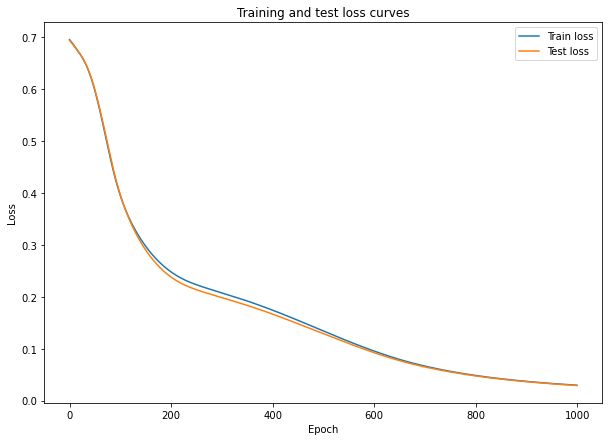

In [128]:
# Convert log lists to numpy arrays
log_epochs = torch.tensor(log_epochs).cpu().numpy()
log_train_loss = torch.tensor(log_train_loss).cpu().numpy()
log_train_acc = torch.tensor(log_train_acc).cpu().numpy()
log_test_loss = torch.tensor(log_test_loss).cpu().numpy()
log_test_acc = torch.tensor(log_test_acc).cpu().numpy()


# Plot the loss curves
plt.figure(figsize=(10, 7))
plt.plot(log_epochs, log_train_loss, label="Train loss")
plt.plot(log_epochs, log_test_loss, label="Test loss")
plt.title("Training and test loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [129]:
# Create log file
training_logs = pd.DataFrame({"Epoch": log_epochs,
                              "Train loss": log_train_loss,
                              "Train accuracy": log_train_acc,
                              "Test loss": log_test_loss,
                              "Test accuracy": log_test_acc})
training_logs.head()

,Epoch,Train loss,Train accuracy,Test loss,Test accuracy
0,0,0.695366,0.365000,0.693894,0.4950
1,1,0.694163,0.486250,0.692709,0.5075
2,2,0.692933,0.496875,0.691503,0.5075
3,3,0.691672,0.502500,0.690286,0.5225
4,4,0.690389,0.508125,0.689052,0.5575


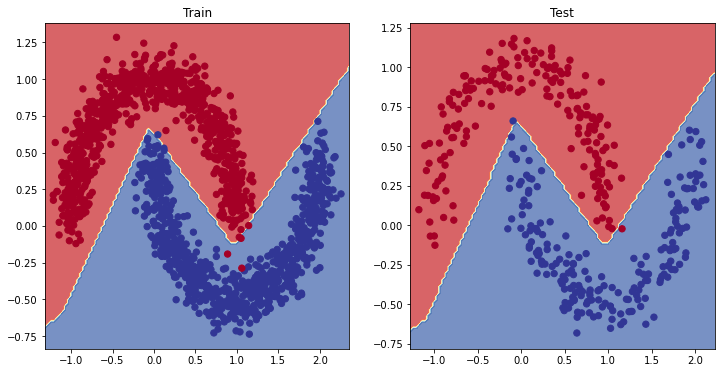

In [130]:
# Plot decision boundary

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 3. Evaluate model

In [131]:
# Get model's predictions
model_0.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()

model_0.eval()
with torch.inference_mode():
    # Forward Pass
    test_logits = model_0(X_test).squeeze()
    
# Convert output to preds and labels
test_preds = torch.sigmoid(test_logits)
test_labels = torch.round(test_preds)

In [134]:
# Confusion matrix
from torchmetrics.classification import ConfusionMatrix
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat(test_labels, y_test)

tensor([[196,   1],
        [  1, 202]])

In [132]:
# Precision
from torchmetrics.classification import BinaryPrecision
precision_fn = BinaryPrecision()
precision_score = precision_fn(test_labels, y_test)
print(f"Precision: {precision_score}")

# Recall
from torchmetrics.classification import BinaryRecall
recall_fn = BinaryPrecision()
recall_score = recall_fn(test_labels, y_test).item()
print(f"Recall: {recall_score}")

# F1
from torchmetrics.classification import BinaryF1Score
f1_fn = BinaryF1Score()
f1_score = f1_fn(test_labels, y_test)
print(f"F1: {f1_score}")

Precision: 0.9950739145278931
Recall: 0.9950739145278931
F1: 0.9950739145278931
